![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/quickstart-ci/AzureMLin10mins.png)

# Quickstart: Train and deploy a model in Azure Machine Learning in 10 minutes

In this quickstart, learn how to get started with Azure Machine Learning. You'll train an image classification model using the [MNIST](https://docs.microsoft.com/azure/open-datasets/dataset-mnist) dataset.

You'll learn how to:

* Download a dataset and look at the data
* Train an image classification model and log metrics using [MLflow](https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E5%88%9D%E6%8E%A2mlflow-tracking-%E4%BF%9D%E6%8C%81ml%E5%AF%A6%E9%A9%97%E7%9A%84%E5%8F%AF%E8%BF%BD%E6%BA%AF%E6%80%A7%E8%88%87%E5%8F%AF%E9%87%8D%E7%8F%BE%E6%80%A7-ff3753fc43bb) (這是個類似 tensorboard 的 open source)
* Deploy the model to do real-time inference

## Import Data

Before you train a model, you need to understand the data you're using to train it. In this section, learn how to:

* Download the MNIST dataset
* Display some sample images

You'll use Azure Open Datasets to get the raw MNIST data files. [Azure Open Datasets](https://docs.microsoft.com/azure/open-datasets/overview-what-are-open-datasets) are curated public datasets that you can use to add scenario-specific features to machine learning solutions for better models. Each dataset has a corresponding class, `MNIST` in this case, to retrieve the data in different ways.

In [1]:
import os
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), "/tmp/qs_data")
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['D:\\tmp\\qs_data\\https%3A\\%2Fazureopendatastorage.azurefd.net\\mnist\\t10k-images-idx3-ubyte.gz',
 'D:\\tmp\\qs_data\\https%3A\\%2Fazureopendatastorage.azurefd.net\\mnist\\t10k-labels-idx1-ubyte.gz',
 'D:\\tmp\\qs_data\\https%3A\\%2Fazureopendatastorage.azurefd.net\\mnist\\train-images-idx3-ubyte.gz',
 'D:\\tmp\\qs_data\\https%3A\\%2Fazureopendatastorage.azurefd.net\\mnist\\train-labels-idx1-ubyte.gz']

### Take a look at the data

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. 

Note this step requires a `load_data` function that's included in an `utils.py` file. This file is placed in the same folder as this notebook. The `load_data` function simply parses the compressed files into numpy arrays.

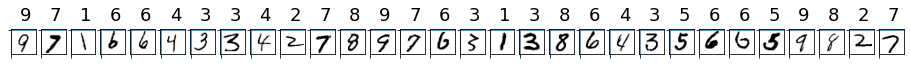

In [2]:
from utils import load_data
import matplotlib.pyplot as plt
import numpy as np
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = (
    load_data(
        glob.glob(
            os.path.join(data_folder, "**/train-images-idx3-ubyte.gz"), recursive=True
        )[0],
        False,
    )
    / 255.0
)
X_test = (
    load_data(
        glob.glob(
            os.path.join(data_folder, "**/t10k-images-idx3-ubyte.gz"), recursive=True
        )[0],
        False,
    )
    / 255.0
)
y_train = load_data(
    glob.glob(
        os.path.join(data_folder, "**/train-labels-idx1-ubyte.gz"), recursive=True
    )[0],
    True,
).reshape(-1)
y_test = load_data(
    glob.glob(
        os.path.join(data_folder, "**/t10k-labels-idx1-ubyte.gz"), recursive=True
    )[0],
    True,
).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline("")
    plt.axvline("")
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Train model and log metrics with MLflow

You'll train the model using the code below. Note that you are using MLflow autologging to track metrics and log model artefacts.

You'll be using the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from the [SciKit Learn framework](https://scikit-learn.org/) to classify the data.

**Note: The model training takes approximately 2 minutes to complete.**

In [8]:
# create the model
import mlflow
import numpy as np
from sklearn.linear_model import LogisticRegression
from azureml.core import Workspace

# connect to your workspace 靠，咱可是練過的，否則又卡在這裡了！
ws = Workspace.from_config(r"d:\hcchen\OneDrive\文件\Jupyter Notebooks\Azure\.azureml\config.json")

# create experiment and start logging to a new run in the experiment
experiment_name = "azure-ml-in10-mins-tutorial"

# set up MLflow to track the metrics
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)
mlflow.autolog()

# set up the Logistic regression model
reg = 0.5
clf = LogisticRegression(
    C=1.0 / reg, solver="liblinear", multi_class="auto", random_state=42
)

# train the model
with mlflow.start_run() as run:
    clf.fit(X_train, y_train)

UnsupportedModelRegistryStoreURIException:  Model registry functionality is unavailable; got unsupported URI 'azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/c27e04e6-ca10-453d-9c80-1931b65eb245/resourceGroups/my_azure_AutoML_resource_group/providers/Microsoft.MachineLearningServices/workspaces/my_azure_AutoML_workspace?' for model registry data storage. Supported URI schemes are: ['', 'file', 'databricks', 'http', 'https', 'postgresql', 'mysql', 'sqlite', 'mssql']. See https://www.mlflow.org/docs/latest/tracking.html#storage for how to run an MLflow server against one of the supported backend storage locations.

## View Experiment
In the left-hand menu in Azure Machine Learning Studio, select __Experiments__ and then select your experiment (azure-ml-in10-mins-tutorial). An experiment is a grouping of many runs from a specified script or piece of code. Information for the run is stored under that experiment. If the name doesn't exist when you submit an experiment, if you select your run you will see various tabs containing metrics, logs, explanations, etc.

## Version control your models with the model registry

You can use model registration to store and version your models in your workspace. Registered models are identified by name and version. Each time you register a model with the same name as an existing one, the registry increments the version. The code below registers and versions the model you trained above. Once you have executed the code cell below you will be able to see the model in the registry by selecting __Models__ in the left-hand menu in Azure Machine Learning Studio.

In [ ]:
# register the model
model_uri = "runs:/{}/model".format(run.info.run_id)
model = mlflow.register_model(model_uri, "sklearn_mnist_model")

## Deploy the model for real-time inference
In this section you learn how to deploy a model so that an application can consume (inference) the model over REST.

### Create deployment configuration
The code cell gets a _curated environment_, which specifies all the dependencies required to host the model (for example, the packages like scikit-learn). Also, you create a _deployment configuration_, which specifies the amount of compute required to host the model. In this case, the compute will have 1CPU and 1GB memory.

In [ ]:
# create environment for the deploy
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.webservice import AciWebservice

# get a curated environment
env = Environment.get(
    workspace=ws, 
    name="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu",
    version=1
)
env.inferencing_stack_version='latest'

# create deployment config i.e. compute resources
aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={"data": "MNIST", "method": "sklearn"},
    description="Predict MNIST with sklearn",
)

### Deploy model

This next code cell deploys the model to Azure Container Instance (ACI).

**Note: The deployment takes approximately 3 minutes to complete.**

In [ ]:
%%time
import uuid
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.model import Model

# get the registered model
model = Model(ws, "sklearn_mnist_model")

# create an inference config i.e. the scoring script and environment
inference_config = InferenceConfig(entry_script="score.py", environment=env)

# deploy the service
service_name = "sklearn-mnist-svc-" + str(uuid.uuid4())[:4]
service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig,
)

service.wait_for_deployment(show_output=True)

The [*scoring script*](score.py) file referenced in the code above can be found in the same folder as this notebook, and has two functions:

1. an `init` function that executes once when the service starts - in this function you normally get the model from the registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally format the input data, run a prediction, and output the predicted result.

### View Endpoint
Once the model has been successfully deployed, you can view the endpoint by navigating to __Endpoints__ in the left-hand menu in Azure Machine Learning Studio. You will be able to see the state of the endpoint (healthy/unhealthy), logs, and consume (how applications can consume the model).

## Test the model service

You can test the model by sending a raw HTTP request to test the web service. 

In [ ]:
# send raw HTTP request to test the web service.
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test) - 1)
input_data = '{"data": [' + str(list(X_test[random_index])) + "]}"

headers = {"Content-Type": "application/json"}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
print("label:", y_test[random_index])
print("prediction:", resp.text)

## Clean up resources

If you're not going to continue to use this model, delete the Model service using:

In [ ]:
# if you want to keep workspace and only delete endpoint (it will incur cost while running)
service.delete()

If you want to control cost further, stop the compute instance by selecting the "Stop compute" button next to the **Compute** dropdown.  Then start the compute instance again the next time you need it.


## Next Steps

In this quickstart, you learned how to run machine learning code in Azure Machine Learning.

Now that you have working code in a development environment, learn how to submit a **_job_** - ideally on a schedule or trigger (for example, arrival of new data).

 [**Learn how to get started with Azure ML Job Submission**](../quickstart-azureml-python-sdk/quickstart-azureml-python-sdk.ipynb) 